<a href="https://colab.research.google.com/github/Dimildizio/DArc_course/blob/main/EDA/PimaKaggle/Pima_indians_kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pima indians diabetes kaggle dataset

### import libs

In [942]:
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt
from scipy.stats import boxcox

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler

In [943]:
%matplotlib inline

### download dataset

In [944]:
%%capture
!wget -O pima.csv https://raw.githubusercontent.com/Dimildizio/DArc_course/main/EDA/PimaKaggle/pima-indians-diabetes.csv

In [945]:
columns = ['pregnancies','glucose', 'blood_pressure', 'skin_thickness', 'insulin', 'BMI', 'pedigree', 'age', 'result']
data = pd.read_csv('pima.csv', names = columns)
data.head()

,pregnancies,glucose,blood_pressure,skin_thickness,insulin,BMI,pedigree,age,result
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


### Check the size of the dataset

In [946]:
data.shape

(768, 9)

### Check for NaNs and data types

In [947]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   pregnancies     768 non-null    int64  
 1   glucose         768 non-null    int64  
 2   blood_pressure  768 non-null    int64  
 3   skin_thickness  768 non-null    int64  
 4   insulin         768 non-null    int64  
 5   BMI             768 non-null    float64
 6   pedigree        768 non-null    float64
 7   age             768 non-null    int64  
 8   result          768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


### Convert float\int 64 to 32 for faster operatinos

In [1030]:
def convert_dtype(data):
  for col in data.columns:
    if data[col].dtype == 'float64':
      data[col] = data[col].astype('float32')

    elif data[col].dtype == 'int64':
      data[col] = data[col].astype('int32')
  return data

In [1032]:
data = convert_dtype(data)

### Get statistics by columns

In [949]:
pd.set_option('display.precision', 3)
data.describe()

,pregnancies,glucose,blood_pressure,skin_thickness,insulin,BMI,pedigree,age,result
count,768.000,768.000,768.000,768.000,768.000,768.000,768.000,768.000,768.000
mean,3.845,120.895,69.105,20.536,79.799,31.993,0.472,33.241,0.349
std,3.370,31.973,19.356,15.952,115.244,7.884,0.331,11.760,0.477
min,0.000,0.000,0.000,0.000,0.000,0.000,0.078,21.000,0.000
25%,1.000,99.000,62.000,0.000,0.000,27.300,0.244,24.000,0.000
50%,3.000,117.000,72.000,23.000,30.500,32.000,0.373,29.000,0.000
75%,6.000,140.250,80.000,32.000,127.250,36.600,0.626,41.000,1.000
max,17.000,199.000,122.000,99.000,846.000,67.100,2.420,81.000,1.000


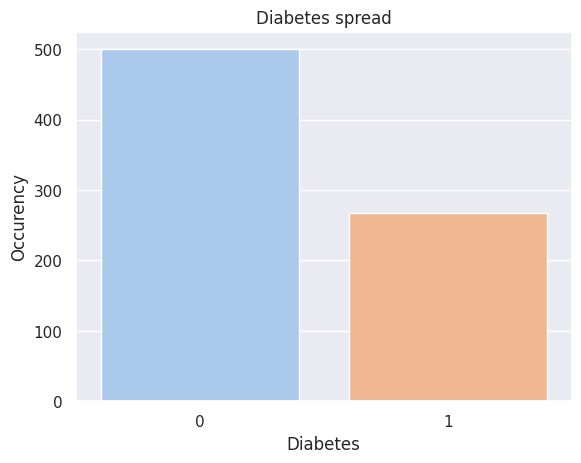

In [950]:
sns.set(style="darkgrid")
sns.set_palette('pastel')
sns.countplot(data=data, x='result')

plt.title('Diabetes spread')
plt.xlabel('Diabetes')
plt.ylabel('Occurency')
plt.show()

Not ideal distibution, so we'll have to address this issue later, possibly by adding sythetic rows.

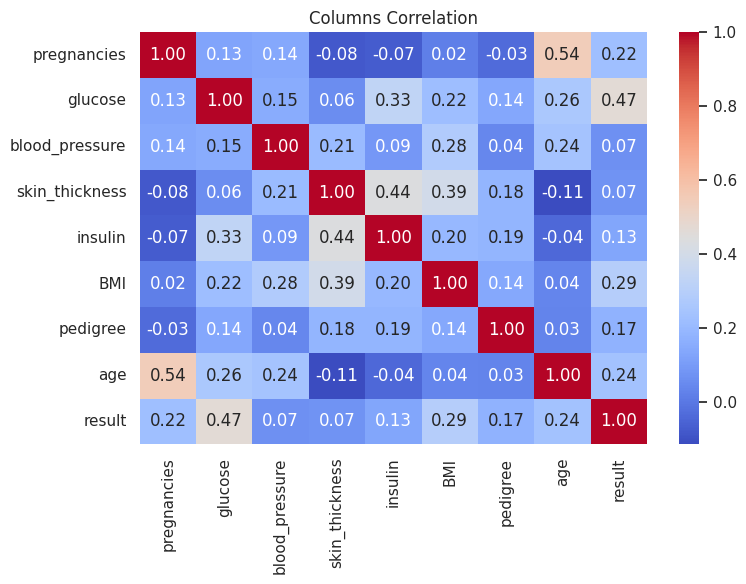

In [951]:
plt.figure(figsize=(8,6))

corr_matrix = data.corr()
sns.heatmap(data=corr_matrix, annot=True, fmt = '.2f', cmap='coolwarm')
plt.title('Columns Correlation')
plt.tight_layout()

Clearly a very "combed" dataset. No NaNs, no high correlation

### Check for skewness

In [952]:
def check_skew(data):
  skewness = data.skew()
  sns.barplot(x=skewness.index, y=skewness)
  plt.xticks(rotation=90)
  plt.xlabel('Columns')
  plt.ylabel('Skewness')
  plt.title('Skewness of Columns')
  plt.show()

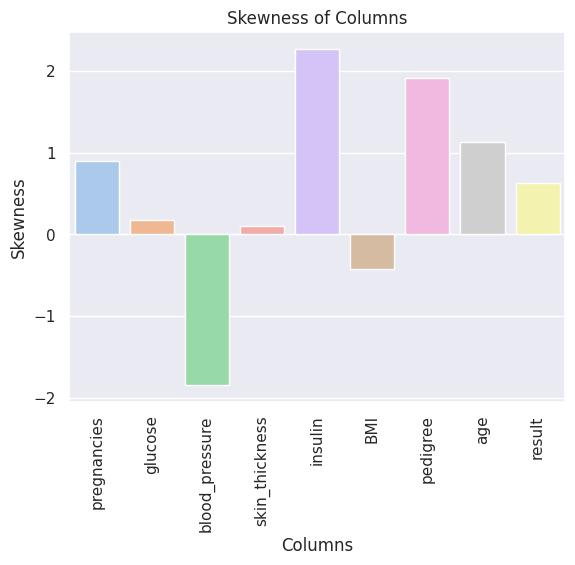

In [953]:
check_skew(data)

### Plot distribution and density curve

In [1033]:
def plot_dist_dense(data, n=3):
  fig, axes = plt.subplots(n, n, figsize=(10,10))
  colors = ['blue', 'green', 'orange', 'red', 'purple', 'cyan', 'magenta', 'yellow', 'brown']

  for num, column in enumerate(data.columns):
    row = num // n
    col = num % n
    ax = axes[row, col]
    sns.histplot(data[column], kde=True, color=colors[num], ax=ax)
  plt.tight_layout()
  plt.show()

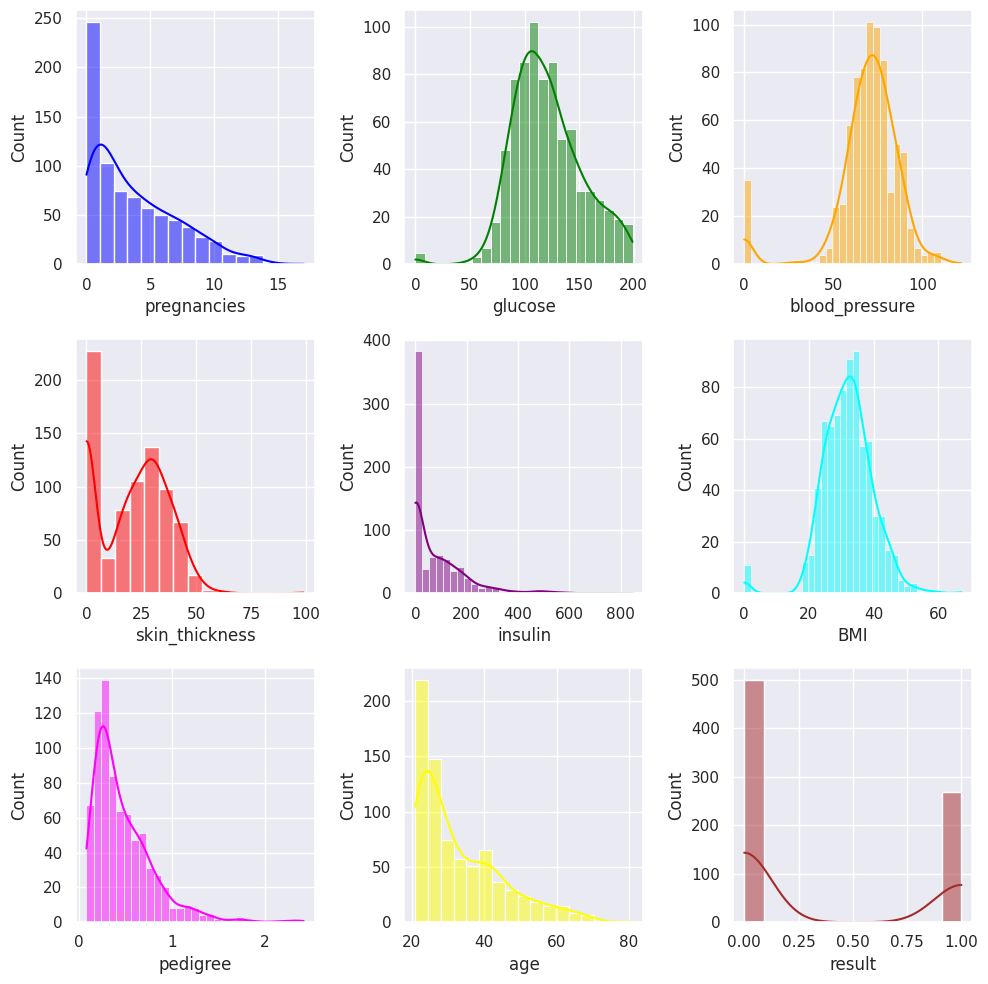

In [1034]:
plot_dist_dense(data)

Looks like we got some outliers as well as some BMI, skin_thickness, insulin, blood_pressure and glucose values 0 which is not possible.

### Check which rows (suspicious) got 0 as values

In [955]:
data[(data['insulin']==0) | (data['BMI']==0) | (data['skin_thickness']==0) | (data['blood_pressure']==0) | (data['glucose']==0)]

,pregnancies,glucose,blood_pressure,skin_thickness,insulin,BMI,pedigree,age,result
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
5,5,116,74,0,0,25.6,0.201,30,0
7,10,115,0,0,0,35.3,0.134,29,0
...,...,...,...,...,...,...,...,...,...
761,9,170,74,31,0,44.0,0.403,43,1
762,9,89,62,0,0,22.5,0.142,33,0
764,2,122,70,27,0,36.8,0.340,27,0
766,1,126,60,0,0,30.1,0.349,47,1


It also seems that for the half of the dataset the parameters haven't been taken and empty values have been filled with 0.
Also if we remove all cols but insulin, it will leave us with the same 374 out of 376 with missing data (extra ones go for glucose and BMI each).

One of the options could be taking mean, median, mode or using linear regression on the dataset with nonzero parameters.

## Check for outliers

There is no reason in finding IQR since there are too many zeros, o we'll try to find outliers manually by looking at the hist graph.

In [956]:
data[(data['insulin'] > 500) | (data['skin_thickness']>70) | (data['pedigree'] > 2)]# | (data['BMI']==0) | (data['skin_thickness']==0) | (data['blood_presure']==0) | (data['glucose']==0)]

,pregnancies,glucose,blood_pressure,skin_thickness,insulin,BMI,pedigree,age,result
4,0,137,40,35,168,43.1,2.288,33,1
8,2,197,70,45,543,30.5,0.158,53,1
13,1,189,60,23,846,30.1,0.398,59,1
228,4,197,70,39,744,36.7,2.329,31,0
247,0,165,90,33,680,52.3,0.427,23,0
286,5,155,84,44,545,38.7,0.619,34,0
370,3,173,82,48,465,38.4,2.137,25,1
409,1,172,68,49,579,42.4,0.702,28,1
445,0,180,78,63,14,59.4,2.420,25,1
579,2,197,70,99,0,34.7,0.575,62,1


Just 2% of the dataset so we could safely remove these rows, but it seems that most of those abnormal values result in positive diabetes so the anomalies in data could be not the problem in statistics but a symptom of a disease.

Which means we shouldn't remove them.

#### Also judging by distribution it's not necessary to cut outliers before applying transfromations to columns

In [957]:
def check_outliers(df, name, size=4):
  sns.boxplot(x=df[name], linewidth=2, width=0.5, notch=True, palette='Blues')
  sns.swarmplot(x=df[name], color='black', size=size)

In [958]:
def get_iqr(df, name, iqr=1.5, side=1):
  if side:
    iqr_result = df[name].describe()['75%'] * iqr
    new_df = df[df[name] > iqr_result]
  else:
    iqr_result = df[name].describe()['25%'] / iqr
    new_df = df[df[name] < iqr_result]
  display(new_df)
  return iqr_result

## Address skewness

As pedigree, age, and pregnancies are the only values which don't have zeros or we're ok with that, we'll work with them for now.

#### Let's prepare some code to see the best transformations

In [959]:
transformed_data = data.copy()

In [960]:
def bxcx(df):
  result, _ = boxcox(df+1) #we add one in case of zero values
  return result

In [961]:
def plot_transforms(data, name):
  operations = [np.sqrt, np.cbrt, np.log, np.log1p]
  opernames = ['square root', 'cube root', 'log', 'log1p', 'boxcox']
  colors = ['magenta', 'blue','orange','indigo', 'red']
  fig, axes = plt.subplots(1, 5, figsize=(12,2))
  fig.suptitle(name)

  def plot_in_subplots(result, num):
    sns.histplot(result, kde=True, color = colors[num], ax=axes[num])
    axes[num].set_xlabel(opernames[num])
    axes[num].set_ylabel('')

  for num in range(4):
    result = data[name].apply(lambda x: operations[num](x))
    plot_in_subplots(result, num)

  result = bxcx(data[name])
  plot_in_subplots(result, 4)

### pedigree

Since there are many values between 1 and 0, we were going to apply np.log1p (adding 1), but taking cube root provides better looking bell distribution

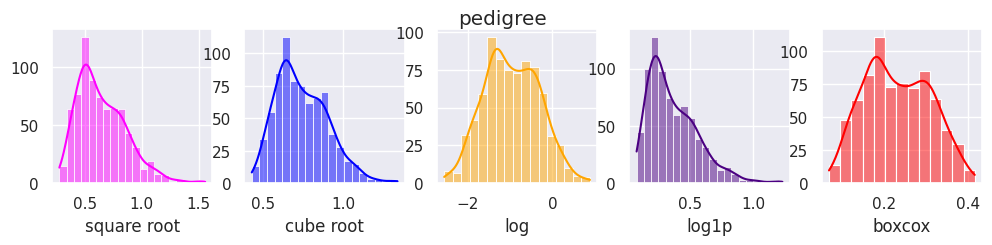

In [962]:
plot_transforms(transformed_data, 'pedigree')

looks like boxcox+1 perfroms better

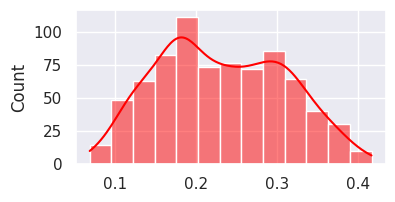

In [963]:
pedigree = data['pedigree'].copy()
pedigree = bxcx(pedigree)
plt.figure(figsize = (4,2))
sns.histplot(pedigree, kde=True, color = 'red')
transformed_data['pedigree'] = pedigree

#### Outliers

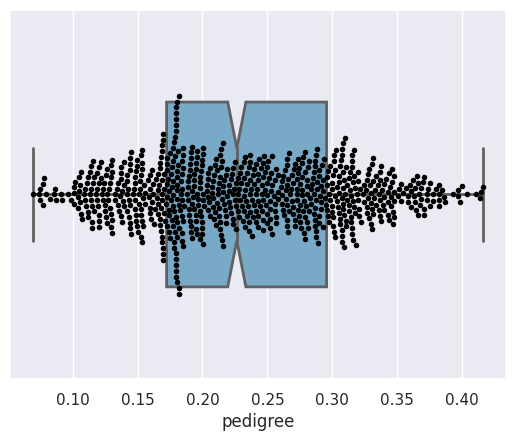

In [964]:
check_outliers(transformed_data, 'pedigree')

### age

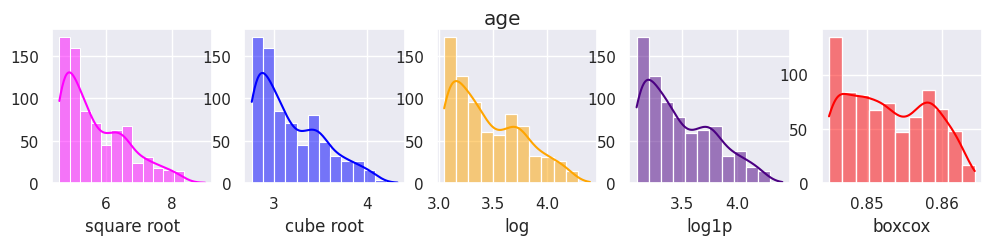

In [965]:
plot_transforms(transformed_data, 'age')

Not much we can do here since the data is very skewed itself, my choice falls on boxcox

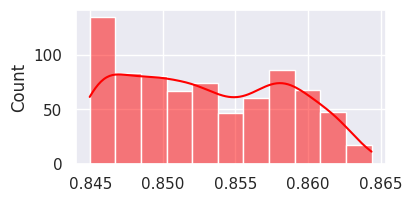

In [966]:
age = data['age'].copy()
age = bxcx(age)
plt.figure(figsize = (4,2))
sns.histplot(age, kde=True, color = 'red')
transformed_data['age'] = age

#### Check for outliers

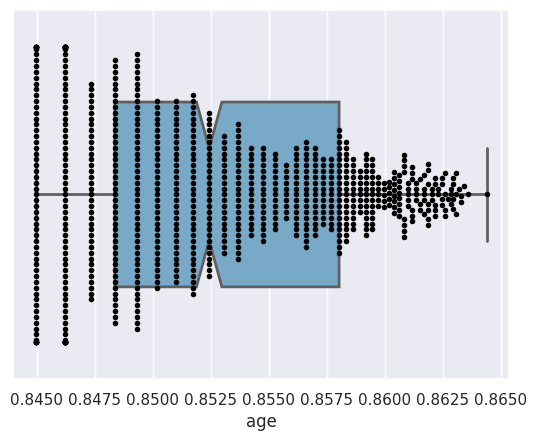

In [967]:
check_outliers(transformed_data, 'age')

In [968]:
get_iqr(transformed_data, 'age')

,pregnancies,glucose,blood_pressure,skin_thickness,insulin,BMI,pedigree,age,result


1.287039181539684

One outlier (fit in by transformation) won't do much

### Pregnacies

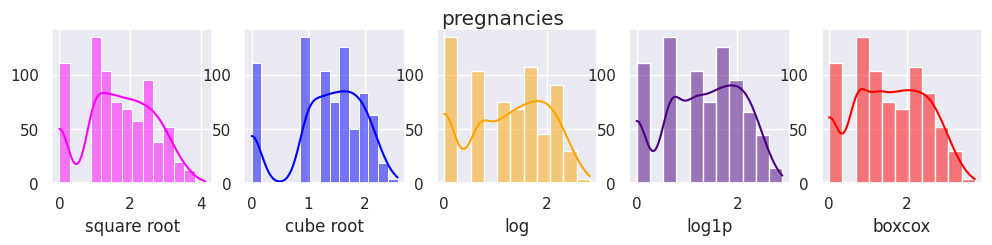

In [969]:
plot_transforms(transformed_data, 'pregnancies')

Not much difference seen here. Let's choose log1p (def not log since we got zeros) for once

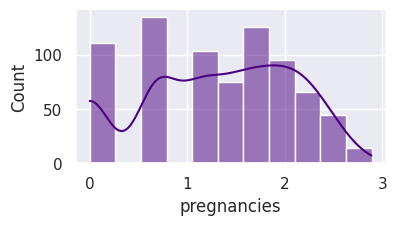

In [970]:
preg = data['pregnancies'].copy()
preg = preg.apply(lambda x: np.log1p(x))
plt.figure(figsize = (4,2))
sns.histplot(preg, kde=True, color='indigo')
transformed_data['pregnancies'] = preg

#### Check for outliers

In [971]:
iqr3 = data['pregnancies'].describe()['75%']*3
data[data['pregnancies'] > iqr3]

,pregnancies,glucose,blood_pressure,skin_thickness,insulin,BMI,pedigree,age,result


In [972]:
get_iqr(transformed_data, 'pregnancies')

,pregnancies,glucose,blood_pressure,skin_thickness,insulin,BMI,pedigree,age,result


2.9188652235829697

There are some outliers in original dataset but they don't get into **IQR * 3** so we can leave them be.

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3544: UserWarning: 6.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


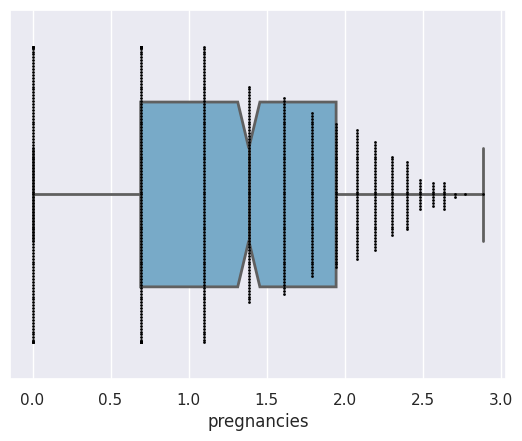

In [973]:
check_outliers(transformed_data, 'pregnancies', 2)

## Fill zero values

In [974]:
def zero_df(df):
  df = pd.DataFrame({'Zeros':df.eq(0).sum()})
  display(df)

In [975]:
zero_df(data)

,Zeros
pregnancies,111
glucose,5
blood_pressure,35
skin_thickness,227
insulin,374
BMI,11
pedigree,0
age,0
result,500


### Glucose

In [976]:
transformed_data[transformed_data['glucose']==0]

,pregnancies,glucose,blood_pressure,skin_thickness,insulin,BMI,pedigree,age,result
75,0.693,0,48,20,0,24.7,0.113,0.846,0
182,0.693,0,74,20,23,27.7,0.198,0.845,0
342,0.693,0,68,35,0,32.0,0.232,0.846,0
349,1.792,0,80,32,0,41.0,0.217,0.857,1
502,1.946,0,68,41,0,39.0,0.314,0.858,1


since we got just 5 zero values we can simply fill 0 glucose with mean.

In [977]:
gluc_df = transformed_data.copy()
gluc_df['glucose'].replace(0, gluc_df['glucose'].mean(), inplace=True)

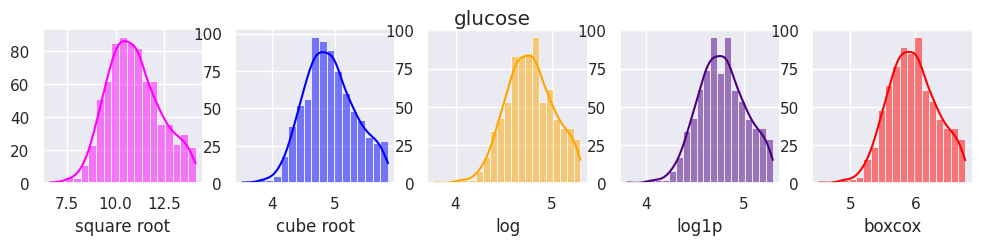

In [978]:
plot_transforms(gluc_df, 'glucose')

Square root transformation looks nice

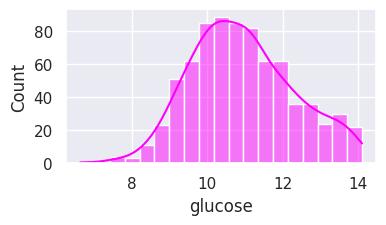

In [979]:
gluc = gluc_df['glucose'].copy()
gluc = gluc.apply(lambda x: np.sqrt(x))
plt.figure(figsize = (4,2))
sns.histplot(gluc, kde=True, color='magenta')
gluc_df['glucose'] = gluc

#### Check for outliers

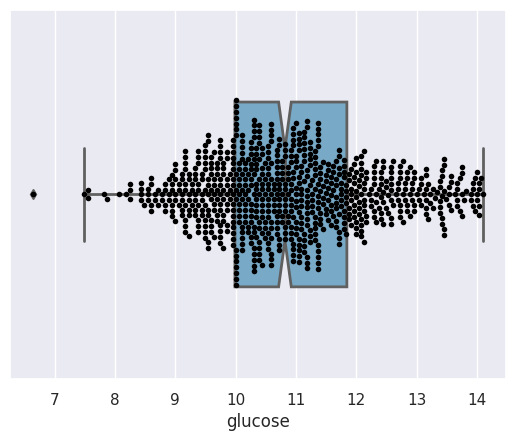

In [980]:
check_outliers(gluc_df, 'glucose')

In [981]:
iqr = get_iqr(gluc_df, 'glucose', 3, side=0)

,pregnancies,glucose,blood_pressure,skin_thickness,insulin,BMI,pedigree,age,result


One outlier, with no insulin, skin thickness and represents control group with no diabetes. We can drop it.

In [982]:
#gluc_df = gluc_df[gluc_df['glucose'] > iqr]

### BMI


In [983]:
gluc_df[gluc_df['BMI']==0]

,pregnancies,glucose,blood_pressure,skin_thickness,insulin,BMI,pedigree,age,result
9,2.197,11.180,96,0,0,0.0,0.167,0.861,1
49,2.079,10.247,0,0,0,0.0,0.200,0.848,0
60,1.099,9.165,0,0,0,0.0,0.200,0.845,0
81,1.099,8.602,0,0,0,0.0,0.087,0.846,0
145,0.000,10.100,75,23,0,0.0,0.284,0.845,0
371,0.000,10.863,64,23,89,0.0,0.398,0.845,0
426,0.000,9.695,0,0,0,0.0,0.178,0.849,0
494,1.386,8.944,0,0,0,0.0,0.135,0.846,0
522,1.946,10.677,0,0,0,0.0,0.143,0.850,0
684,1.792,11.662,82,0,0,0.0,0.298,0.863,0


Same here. ~1.5% of all dataset could be filled with means with no issues

In [984]:
bmi_df = gluc_df.copy()
bmi_df['BMI'].replace(0, bmi_df['BMI'].mean(), inplace=True)
bmi_df[bmi_df['BMI']<=0]

,pregnancies,glucose,blood_pressure,skin_thickness,insulin,BMI,pedigree,age,result


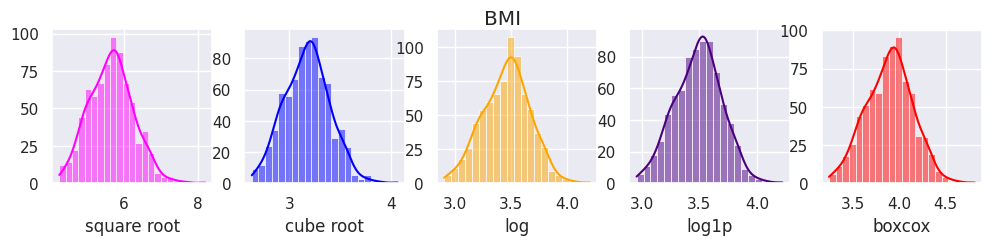

In [985]:
plot_transforms(bmi_df, 'BMI')

Every single one transformation looks nice. Let's do log

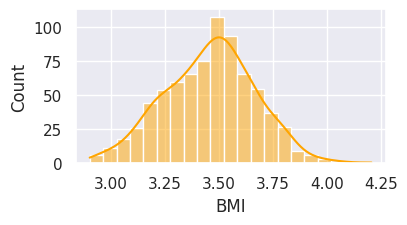

In [986]:
bmi = bmi_df['BMI'].copy()
bmi = bmi.apply(lambda x: np.log(x))
plt.figure(figsize = (4,2))
sns.histplot(bmi, kde=True, color='orange')
bmi_df['BMI'] = bmi

#### Check for outliers

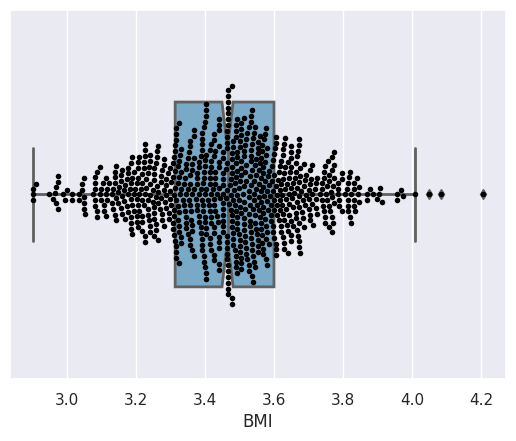

In [987]:
check_outliers(bmi_df, 'BMI')

In [988]:
get_iqr(bmi_df, 'BMI')

,pregnancies,glucose,blood_pressure,skin_thickness,insulin,BMI,pedigree,age,result


5.400072298074959

Three outliers but they don't go beyond IQR * 1.5 so we're ok with them

### Blood pressure

blood pressure has 35 zero values and we assume that all the test participants were alive. 35 of 768 is coming close to 5% which I'd select as a limit for filling with mean, but 4.5 is lower than 5, so we'll do the same operation here as well.

In [989]:
bp_df = bmi_df.copy()
bp_df['blood_pressure'].replace(0, bp_df['blood_pressure'].mean(), inplace=True)
bp_df[bp_df['blood_pressure']==0]

,pregnancies,glucose,blood_pressure,skin_thickness,insulin,BMI,pedigree,age,result


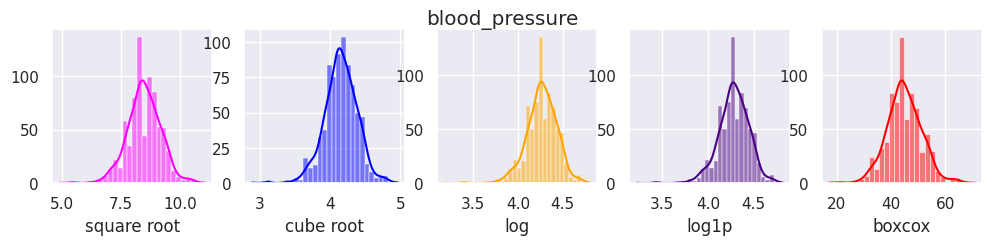

In [990]:
plot_transforms(bp_df, 'blood_pressure')

Looks like cube root is a winner, smoothing outliers (and fit outlier into iqr1.5)

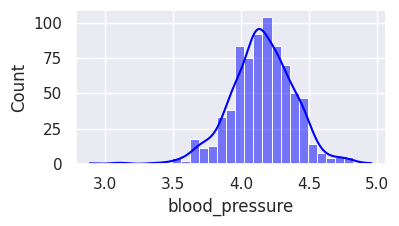

In [991]:
bp = bp_df['blood_pressure'].copy()
bp = bp.apply(lambda x: np.cbrt(x))
plt.figure(figsize = (4,2))
sns.histplot(bp, kde=True, color='blue')
bp_df['blood_pressure'] = bp

#### Check for outliers

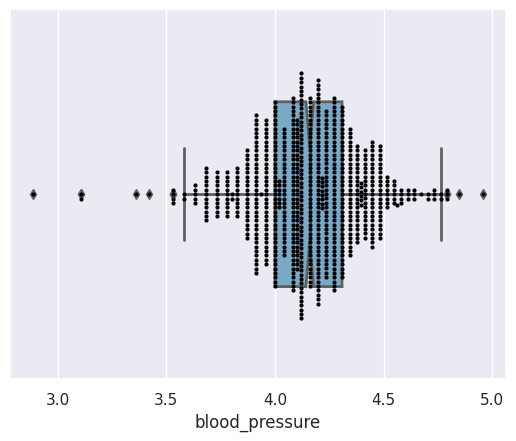

In [992]:
check_outliers(bp_df, 'blood_pressure', 3)

In [993]:
get_iqr(bp_df, 'blood_pressure')

,pregnancies,glucose,blood_pressure,skin_thickness,insulin,BMI,pedigree,age,result


6.46330407009565

In [994]:
get_iqr(bp_df, 'blood_pressure', side=0)

,pregnancies,glucose,blood_pressure,skin_thickness,insulin,BMI,pedigree,age,result


2.6666666666666665

Some people got low blood pressure but nothing special that would go below IQR/1.5 on cube root (one gows on square root though)

## Predict empty (0) parameters

In [995]:
zero_df(bp_df)

,Zeros
pregnancies,111
glucose,0
blood_pressure,0
skin_thickness,227
insulin,374
BMI,0
pedigree,0
age,0
result,500


Now we got two parameters - insulin and skin_thinkness we need to fill. Since there are too many empty values we can't fill them with mean or median, so, we could use a linear regression to approximate the values.

### Skin thickness

In [996]:
bp_df[(bp_df['insulin']==0) & (bp_df['skin_thickness']==0)]

,pregnancies,glucose,blood_pressure,skin_thickness,insulin,BMI,pedigree,age,result
2,2.197,13.528,4.000,0,0,3.148,0.305,0.854,1
5,1.792,10.770,4.198,0,0,3.243,0.150,0.853,0
7,2.398,10.724,4.104,0,0,3.564,0.110,0.852,0
9,2.197,11.180,4.579,0,0,3.466,0.167,0.861,1
10,1.609,10.488,4.514,0,0,3.627,0.145,0.853,0
...,...,...,...,...,...,...,...,...,...
757,0.000,11.091,4.160,0,0,3.592,0.179,0.861,1
758,0.693,10.296,4.236,0,0,3.624,0.148,0.850,0
759,1.946,13.784,4.514,0,0,3.570,0.189,0.863,1
762,2.303,9.434,3.958,0,0,3.114,0.115,0.855,0


As we can see if the insulin is not measured, the skin_thinkness is not measured as well

In [997]:
get_iqr(bp_df, 'skin_thickness', 3)

,pregnancies,glucose,blood_pressure,skin_thickness,insulin,BMI,pedigree,age,result
579,1.099,14.036,4.121,99,0,3.547,0.284,0.862,1


96.0

Skin thickness 99 is clearly a mistake. So let's set it to 0 and predict it from anew.

In [998]:
bp_df.at[579, 'skin_thickness'] = 0
bp_df.loc[579]

pregnancies        1.099
glucose           14.036
blood_pressure     4.121
skin_thickness     0.000
insulin            0.000
BMI                3.547
pedigree           0.284
age                0.862
result             1.000
Name: 579, dtype: float64

#### Split into test and train datasets, extract Xs and ys

In [999]:
skin_df = bp_df.drop(['insulin'], axis=1)

test_skin_df = skin_df[skin_df['skin_thickness'] == 0]
X_test_skin = test_skin_df.drop(['skin_thickness'], axis=1)

train_skin_df = skin_df[skin_df['skin_thickness'] > 0]
X_train_skin = train_skin_df.drop(['skin_thickness'], axis=1)
y_train_skin = train_skin_df['skin_thickness']

#### Create a model

In [1000]:
skin_model = LinearRegression()

#### Create cross-validation

In [1001]:
skin_cv = KFold(n_splits=5, random_state=13, shuffle=True)

In [1002]:
skin_score = (-cross_val_score(skin_model, X_train_skin, y_train_skin, cv=skin_cv, scoring = 'neg_mean_squared_error')).mean()
print('mse:', round(skin_score, 2), '\nmae:', round(skin_score**.5, 2))

mse: 55.23 
mae: 7.43


So average mistake is about 7.5. 10-15% is ok for our needs

#### Train model

In [1003]:
mse_cv_sk = []
for train_idx, val_idx in skin_cv.split(X_train_skin):
  X_train_sk, X_val_sk = X_train_skin.iloc[train_idx], X_train_skin.iloc[val_idx]
  y_train_sk, y_val_sk = y_train_skin.iloc[train_idx], y_train_skin.iloc[val_idx]

  skin_model.fit(X_train_sk, y_train_sk)
  y_pred_sk = skin_model.predict(X_val_sk)
  mse_sk = mean_squared_error(y_val_sk, y_pred_sk)
  mse_cv_sk.append(mse_sk)

avg_mse = np.mean(mse_cv_sk)
print('Mean MSE:', avg_mse)

Mean MSE: 55.22693648114934


#### Predict

In [1004]:
pred_skin = skin_model.predict(X_test_skin)

#### Combine dataset together

In [1005]:
dfsk = X_test_skin.copy()
dfsk['skin_thickness'] = np.round(pred_skin).astype("int32")
dfsk = dfsk[train_skin_df.columns]

thick_df = pd.concat([train_skin_df, dfsk])
thick_df = thick_df.sort_index().reset_index(drop=True)

In [1006]:
thick_df

,pregnancies,glucose,blood_pressure,skin_thickness,BMI,pedigree,age,result
0,1.946,12.166,4.160,35,3.515,0.296,0.860,1
1,0.693,9.220,4.041,29,3.281,0.219,0.854,0
2,2.197,13.528,4.000,19,3.148,0.305,0.854,1
3,0.693,9.434,4.041,23,3.336,0.130,0.845,0
4,0.000,11.705,3.420,35,3.764,0.414,0.855,1
...,...,...,...,...,...,...,...,...
763,2.398,10.050,4.236,48,3.493,0.133,0.863,0
764,1.099,11.045,4.121,27,3.605,0.214,0.851,0
765,1.792,11.000,4.160,23,3.266,0.173,0.853,0
766,0.693,11.225,3.915,27,3.405,0.218,0.860,1


### Insulin

#### Split for test and train

In [1007]:
ins_df = bp_df.copy()
ins_df['skin_thickness'] = thick_df['skin_thickness']

train_ins = ins_df[ins_df['insulin'] > 0]
test_ins = ins_df[ins_df['insulin'] == 0]

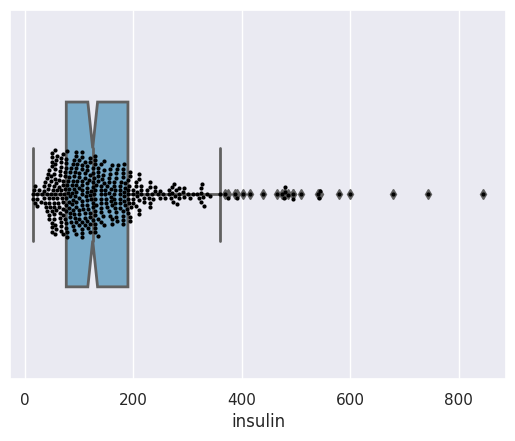

In [1010]:
check_outliers(train_ins, 'insulin', 3)

<Axes: xlabel='insulin', ylabel='Count'>

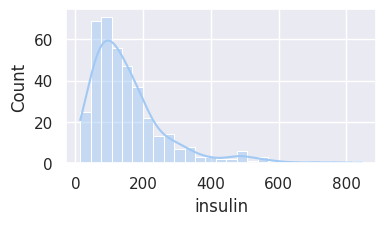

In [1011]:
plt.figure(figsize=(4,2))
sns.histplot(train_ins['insulin'], kde=True)

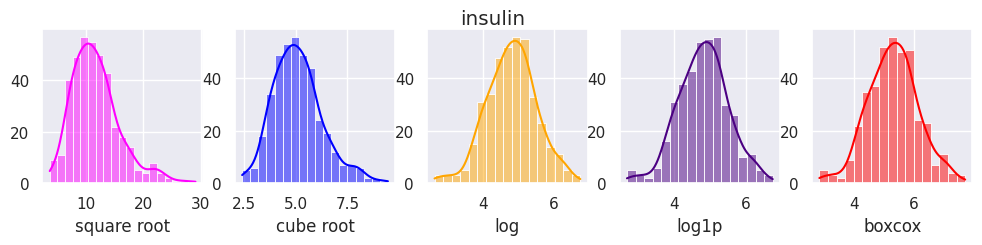

In [1012]:
plot_transforms(train_ins, 'insulin')

<ipython-input-1013-559be58abe70>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_ins['insulin'] = ins


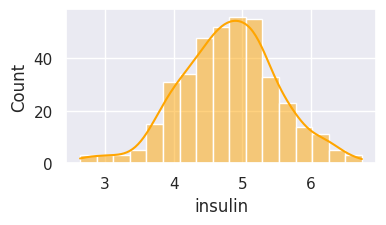

In [1013]:
ins = train_ins['insulin'].copy()
ins = ins.apply(lambda x: np.log(x))
plt.figure(figsize = (4,2))
sns.histplot(ins, kde=True, color='orange')
train_ins['insulin'] = ins

In [1014]:
get_iqr(train_ins, 'insulin')

,pregnancies,glucose,blood_pressure,skin_thickness,insulin,BMI,pedigree,age,result


7.87053610824073

#### Split for X and target data

In [1016]:
X_train_ins = train_ins.drop(['insulin'], axis=1)
y_train_ins = train_ins['insulin']

X_test_ins = test_ins.drop(['insulin'], axis=1)
y_test_ins = test_ins['insulin']

#### Split for train and val datasets

In [1017]:
X_ins_train, X_ins_val, y_ins_train, y_ins_val = train_test_split(X_train_ins, y_train_ins, test_size=0.2, random_state=42)

#### Apply Scaler

In [1018]:
scaler = StandardScaler()

X_i_train_scaled = scaler.fit_transform(X_ins_train)
X_i_val_scaled = scaler.transform(X_ins_val)
X_i_test_scaled = scaler.transform(X_test_ins)

#### Create and train model

In [1019]:
ins_model = RidgeCV(alphas=[0.1, 1, 10.0])
ins_model.fit(X_i_train_scaled, y_ins_train)

RidgeCV(alphas=[0.1, 1, 10.0])

In [1020]:
ins_model.alpha_

10.0

In [1021]:
r2_ins = round(ins_model.score(X_i_val_scaled, y_ins_val), 3)
y_val_pred_i = ins_model.predict(X_i_val_scaled)
mse_ins = mean_squared_error(y_val_pred_i, y_ins_val)
print(f'R2 score:{r2_ins}\nMSE: {round(mse_ins,2)}\nMAE: {round(mse_ins**0.5, 2)}')

R2 score:0.472
MSE: 0.27
MAE: 0.52


#### Try RandomForest

In [1022]:
ins_model2 = RandomForestRegressor(n_estimators=100, max_depth=3)
ins_model2.fit(X_i_train_scaled, y_ins_train)
y_val_i_forest = ins_model2.predict(X_i_val_scaled)
mse_ins_forest = mean_squared_error(y_val_i_forest, y_ins_val)
print(f'MSE: {round(mse_ins_forest, 2)}\nMAE: {round(mse_ins_forest**0.5, 2)}')

MSE: 0.26
MAE: 0.51


Terrible result (look at r2) but still better than using mean.

#### Predict

In [1023]:
pred_ins = ins_model.predict(X_i_test_scaled)

In [1024]:
dfi = X_test_ins.copy()
dfi['insulin'] = pred_ins
df = pd.concat([train_ins, dfi])
df = df.sort_index().reset_index(drop=True)
df = df[data.columns]
df

,pregnancies,glucose,blood_pressure,skin_thickness,insulin,BMI,pedigree,age,result
0,1.946,12.166,4.160,35,5.246,3.515,0.296,0.860,1
1,0.693,9.220,4.041,29,4.197,3.281,0.219,0.854,0
2,2.197,13.528,4.000,19,5.403,3.148,0.305,0.854,1
3,0.693,9.434,4.041,23,4.543,3.336,0.130,0.845,0
4,0.000,11.705,3.420,35,5.124,3.764,0.414,0.855,1
...,...,...,...,...,...,...,...,...,...
763,2.398,10.050,4.236,48,5.193,3.493,0.133,0.863,0
764,1.099,11.045,4.121,27,4.892,3.605,0.214,0.851,0
765,1.792,11.000,4.160,23,4.718,3.266,0.173,0.853,0
766,0.693,11.225,3.915,27,4.928,3.405,0.218,0.860,1


## Have a look at the transfromed data

In [1028]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   pregnancies     768 non-null    float64
 1   glucose         768 non-null    float64
 2   blood_pressure  768 non-null    float64
 3   skin_thickness  768 non-null    int32  
 4   insulin         768 non-null    float64
 5   BMI             768 non-null    float64
 6   pedigree        768 non-null    float32
 7   age             768 non-null    float64
 8   result          768 non-null    int32  
dtypes: float32(1), float64(6), int32(2)
memory usage: 45.1 KB


In [1029]:
df.describe()

,pregnancies,glucose,blood_pressure,skin_thickness,insulin,BMI,pedigree,age,result
count,768.000,768.000,768.000,768.000,768.000,768.000,768.000,768.000,768.000
mean,1.311,10.946,4.152,28.600,4.792,3.458,0.232,0.853,0.349
std,0.770,1.365,0.237,9.271,0.583,0.211,0.078,0.005,0.477
min,0.000,6.633,2.884,7.000,2.639,2.901,0.069,0.845,0.000
25%,0.693,9.987,4.000,22.000,4.431,3.314,0.172,0.848,0.000
50%,1.386,10.817,4.160,28.000,4.780,3.466,0.226,0.852,0.000
75%,1.946,11.843,4.309,35.000,5.165,3.600,0.296,0.858,1.000
max,2.890,14.107,4.960,63.000,6.741,4.206,0.416,0.864,1.000
